In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Affinity task 4/c4_submission_form.csv")
df1 = pd.read_csv("/content/drive/MyDrive/Affinity task 4/orders.csv")
print(df.shape)
# print(df.head())
print(df1.shape)
# print(df1.head())

(405, 5)
(16542, 41)


In [ ]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.3 MB/s eta 0:00:00


<ipython-input-12-0bbf10c69c66>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_campaigns = orders_data.groupby(['dim_team_key', 'week']).apply(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 2
[LightGBM] [Info] Start training from score 32.103774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

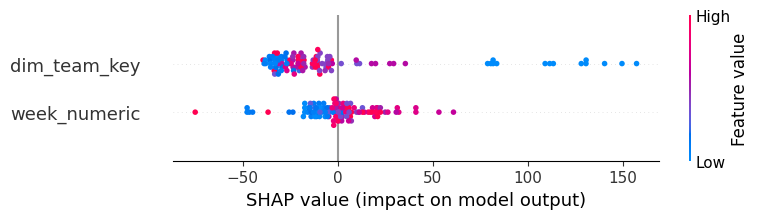

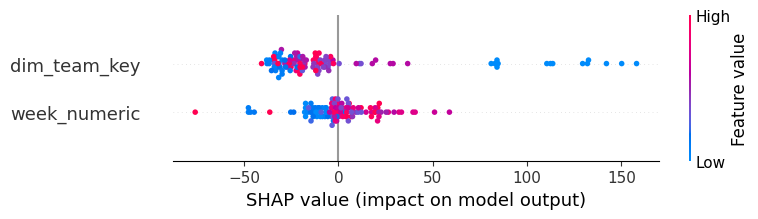

Predictions saved to predictions.csv
Models saved for production.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import shap
import joblib

# Load datasets
orders_path = '/content/drive/MyDrive/Affinity task 4/orders.csv'
submission_path = '/content/drive/MyDrive/Affinity task 4/c4_submission_form.csv'

orders_data = pd.read_csv(orders_path)
submission_data = pd.read_csv(submission_path)

# Step 1: Preprocess `orders.csv`
# Convert dates to datetime
orders_data['startdate'] = pd.to_datetime(orders_data['startdate'], errors='coerce')
orders_data['enddate'] = pd.to_datetime(orders_data['enddate'], errors='coerce')

# Add a week column (starting on Sunday)
orders_data['week'] = orders_data['startdate'].dt.to_period('W-SUN')

# Convert `dim_team_key` to numeric using LabelEncoder
label_encoder = LabelEncoder()
orders_data['dim_team_key'] = label_encoder.fit_transform(orders_data['dim_team_key'])

# Calculate weekly incoming orders
weekly_orders = orders_data.groupby(['dim_team_key', 'week']).size().reset_index(name='incoming_orders')

# Convert `week` to numeric (e.g., week number since start of data)
weekly_orders['week_numeric'] = (weekly_orders['week'] - weekly_orders['week'].min()).apply(lambda x: x.n)

# Calculate in-flight campaigns for each week
weekly_campaigns = orders_data.groupby(['dim_team_key', 'week']).apply(
    lambda df: ((df['startdate'] <= df['week'].dt.end_time) & (df['enddate'] >= df['week'].dt.start_time)).sum()
).reset_index(name='in_flight_campaigns')

# Merge aggregated features
weekly_campaigns['week_numeric'] = (weekly_campaigns['week'] - weekly_campaigns['week'].min()).apply(lambda x: x.n)
weekly_data = pd.merge(weekly_orders, weekly_campaigns, on=['dim_team_key', 'week', 'week_numeric'], how='outer')

# Drop original `week` column as it is now represented as `week_numeric`
weekly_data = weekly_data.drop(columns=['week'])

# Step 2: Prepare `c4_submission_form.csv`
# Fix `week_start` parsing with the correct format
submission_data['week'] = pd.to_datetime(submission_data['week_start'], format='%d-%m-%Y').dt.to_period('W-SUN')
submission_data['week_numeric'] = (submission_data['week'] - weekly_orders['week'].min()).apply(lambda x: x.n)
submission_data['dim_team_key'] = label_encoder.transform(submission_data['dim_team_key'])

# Align submission data with historical data
X_train = weekly_data.drop(columns=['incoming_orders', 'in_flight_campaigns'])
y_train_orders = weekly_data['incoming_orders']
y_train_campaigns = weekly_data['in_flight_campaigns']

# Train-test split
X_train_orders, X_test_orders, y_train_orders, y_test_orders = train_test_split(
    X_train, y_train_orders, test_size=0.2, random_state=42
)
X_train_campaigns, X_test_campaigns, y_train_campaigns, y_test_campaigns = train_test_split(
    X_train, y_train_campaigns, test_size=0.2, random_state=42
)

# Step 3: Train Models
# LightGBM for incoming orders
lgb_orders = LGBMRegressor(random_state=42)
lgb_orders.fit(X_train_orders, y_train_orders)

# LightGBM for in-flight campaigns
lgb_campaigns = LGBMRegressor(random_state=42)
lgb_campaigns.fit(X_train_campaigns, y_train_campaigns)

# Step 4: Evaluate Models
def evaluate_rmse(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for {label}: {rmse}")
    return rmse

rmse_orders = evaluate_rmse(lgb_orders, X_test_orders, y_test_orders, "Incoming Orders")
rmse_campaigns = evaluate_rmse(lgb_campaigns, X_test_campaigns, y_test_campaigns, "In-Flight Campaigns")

# Step 5: Feature Importance
explainer_orders = shap.TreeExplainer(lgb_orders)
shap_values_orders = explainer_orders.shap_values(X_test_orders)
shap.summary_plot(shap_values_orders, X_test_orders)

explainer_campaigns = shap.TreeExplainer(lgb_campaigns)
shap_values_campaigns = explainer_campaigns.shap_values(X_test_campaigns)
shap.summary_plot(shap_values_campaigns, X_test_campaigns)

# Step 6: Predict for Submission Data
submission_data['predicted_incoming_orders'] = lgb_orders.predict(
    submission_data[['dim_team_key', 'week_numeric']]
)
submission_data['predicted_in_flight_campaigns'] = lgb_campaigns.predict(
    submission_data[['dim_team_key', 'week_numeric']]
)

# Save predictions
submission_data[['dim_team_key', 'week_start', 'predicted_incoming_orders', 'predicted_in_flight_campaigns']].to_csv(
    'predictions.csv', index=False
)
print("Predictions saved to predictions.csv")

# Step 7: Save Models for Production
joblib.dump(lgb_orders, 'lgb_orders.pkl')
joblib.dump(lgb_campaigns, 'lgb_campaigns.pkl')
print("Models saved for production.")
